In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import nn
import json
import matplotlib.patches
import matplotlib.collections
import matplotlib
import alphashape
import numpy.random as rng



In [2]:
df = pd.read_csv('r490.csv')
df = df[df['r1_charge_heater'] >= 0]

X = np.array(df[['r1_temp', 'r2_temp', 'r1_pressure', 'r2_pressure']])
Y = np.array(df[['r1_charge_heater', 'process_ron', 'process_yield']])

In [3]:
path = 'traces/r490/noiseless_easy_eg.json'
with open(path, 'r') as f:
    results = json.load(f)
traces = np.array(results['traces'])
traces.shape

(50, 101)

In [4]:
min_ron = results['exp_cfg']['min_ron']
min_yield = results['exp_cfg']['min_yield']
feasible_ix = (Y[:,1] >= min_ron) & (Y[:,2] >= min_yield)
Xfeasible = X[feasible_ix,:]

In [5]:
n_selected = 5
n_exps = 100
r1p = 70
r2p = 70
temps = np.linspace(126, 168, 100)
Xstar = []
for r1t in temps:
    for r2t in temps:
        Xstar.append([r1t, r2t, r1p, r2p])
Xstar = np.array(Xstar)

selected_traces = rng.permutation(traces.shape[0])[:n_selected]

In [6]:
yhats = []
for trace_id in selected_traces:
    
    Xtraced = X[traces[trace_id,:n_exps],:]
    Ytraced = Y[traces[trace_id,:n_exps],:]
    
    model = nn.FeedforwardNN(results['model_cfg'])
    model.train(Xtraced, Ytraced)
    
    yhat = model.predict(Xstar)
    yhats.append(yhat)

2022-03-26 14:22:33.698442: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-26 14:22:33.698476: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: x299
2022-03-26 14:22:33.698482: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: x299
2022-03-26 14:22:33.698586: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-03-26 14:22:33.698607: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-03-26 14:22:33.698612: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-03-26 14:22:33.698812: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

In [7]:
titles = [  ('Charge Heater (GJ/Hour)', 'cividis', 1e-6),
            ('Process RON', 'viridis', 1),
            ('Process Yield', 'inferno', 1) ]
dependent_var = 0

Text(0.5, 0, 'Charge Heater (GJ/Hour)')

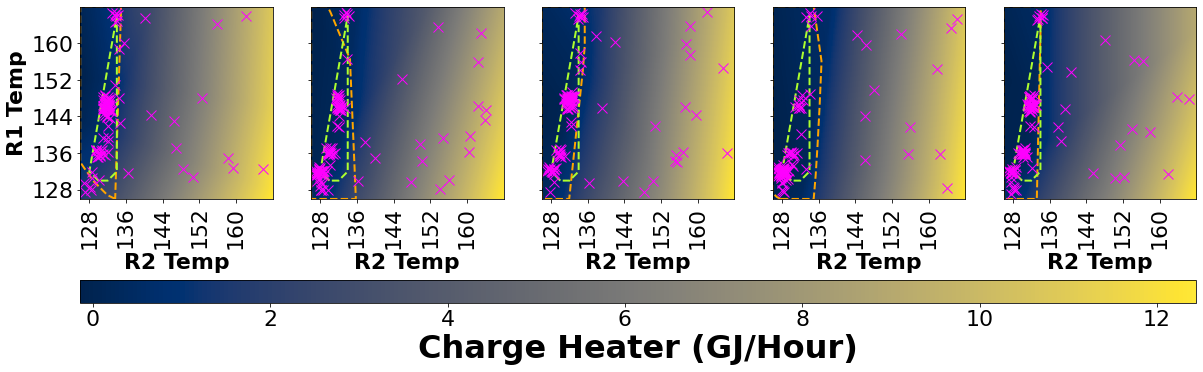

In [8]:
f, axes = plt.subplots(1, n_selected, figsize=(20, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    yhat = yhats[i]
    
    feasible_yhat_ix = (yhat[:,1] >= min_ron) & (yhat[:,2] >= min_yield)
    feasible_Xstar = Xstar[feasible_yhat_ix,:]

    points = feasible_Xstar[:,[1,0]].tolist()
    hull = alphashape.alphashape(points, 0)
    predicted_feasible_xy = hull.exterior.coords.xy
    
    points = Xfeasible[:,[1,0]].tolist()
    hull = alphashape.alphashape(points, 0.)
    actual_feasible_xy = hull.exterior.coords.xy
    
    
    M = np.reshape(yhat[:,dependent_var], (len(temps), len(temps))) * titles[dependent_var][2]

    n,m = M.shape
    extent=[126, 168, 126, 168]
    
    im = ax.imshow(M, origin='lower', cmap=titles[dependent_var][1], extent=extent)
        
    trace_id = selected_traces[i]
    
    Xtraced = X[traces[trace_id,:n_exps],:]
    
    R1traced = Xtraced[:,0] + rng.randn(Xtraced.shape[0]) * 0.5
    R2traced = Xtraced[:,1] + rng.randn(Xtraced.shape[0]) * 0.5

    ax.plot(R2traced,
            R1traced,
            linestyle='',
            marker='x', markersize='10', color='magenta')

    ax.add_patch(matplotlib.patches.Polygon(list(zip(*predicted_feasible_xy)), edgecolor='orange', linewidth=2, linestyle='--', fill=None))
    ax.add_patch(matplotlib.patches.Polygon(list(zip(*actual_feasible_xy)), edgecolor='greenyellow', linewidth=2, linestyle='--', fill=None))
    
    ax.tick_params(axis='x', labelsize=22, rotation=90)
    ax.tick_params(axis='y', labelsize=22)
    ax.set_xticks(np.arange(128, 168, 8))
    ax.set_yticks(np.arange(128, 168, 8))

    ax.set_xlabel('R2 Temp', fontsize=22, fontweight='bold')
    if i == 0:
        ax.set_ylabel('R1 Temp', fontsize=22, fontweight='bold')
    # cbar = f.colorbar(im, ax=ax, shrink=0.8)
    # cbar.ax.tick_params(labelsize=32) 
    # ax.set_title(titles[dependent_var][0], fontsize=48, fontweight='bold')
cbar = f.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal', aspect=50)
cbar.ax.tick_params(labelsize=22) 
cbar.ax.set_xlabel('Charge Heater (GJ/Hour)', fontsize=32, fontweight='bold')
#f.tight_layout()
